In [1]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import numpy as np
import pandas as pd

from scipy.stats import entropy
from copy import deepcopy as copy
from importlib import reload

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array, as_float_array

from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier

from scipy.stats import entropy
from scipy import sparse

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import sys
sys.path.append('../')

In [21]:
import mlrank.dichtomization as dichtomization
import mlrank.orthogonalization as orthogonalization

reload(dichtomization)
reload(orthogonalization)

MaxentropyMedianDichtomizationTransformer = dichtomization.MaxentropyMedianDichtomizationTransformer
MLRankClosedTransformer = orthogonalization.MLRankClosedTransformer

# Эксперимент на синтетике

In [30]:
from sklearn.utils.multiclass import type_of_target

type_of_target(np.random.normal(size=100))

'continuous'

In [22]:
X, y, coefs = make_regression(n_samples=1000, n_features=8, n_informative=4, n_targets=3, coef=True, random_state=42)
X = np.concatenate([X, y[:, :-1]], axis=1)
y = y[:, -1]#.reshape(-1, 1)

In [23]:
models = {
    'rf': LGBMClassifier(boosting_type='rf', bagging_freq=5, bagging_fraction=.05, feature_fraction=.1),
    'lr': LogisticRegression(random_state=42, multi_class='ovr', solver='liblinear', C=10000, tol=1e-2, n_jobs=-1),
    'svc': LinearSVC(multi_class='ovr'),
}

In [24]:
transform = MLRankClosedTransformer(models['lr'], exhausitve=True, verbose=True)

In [25]:
features, indices = transform.fit_transform(X)

processing starting feature 0
processing starting feature 1
processing starting feature 2
processing starting feature 3
processing starting feature 4
processing starting feature 5
processing starting feature 6
processing starting feature 7
processing starting feature 8
processing starting feature 9


In [26]:
indices

array([[0, 3, 6, 8, 5, 1, 7, 9, 4, 2],
       [1, 9, 6, 3, 8, 5, 0, 2, 4, 7],
       [2, 4, 3, 0, 8, 9, 6, 1, 7, 5],
       [3, 0, 4, 1, 8, 5, 7, 9, 2, 6],
       [4, 1, 5, 6, 9, 2, 8, 7, 3, 0],
       [5, 1, 7, 4, 9, 2, 8, 0, 6, 3],
       [6, 9, 1, 3, 4, 5, 8, 2, 0, 7],
       [7, 8, 6, 2, 0, 4, 9, 1, 5, 3],
       [8, 7, 6, 9, 0, 5, 2, 1, 4, 3],
       [9, 6, 1, 0, 8, 5, 7, 3, 4, 2]])

In [27]:
np.where(coefs.sum(1) > 0)[0].tolist() + [8, 9]

[0, 2, 4, 5, 8, 9]

In [28]:
unique_ix = np.unique(indices).tolist()
ix_counts = {i: 0 for i in unique_ix}

for row in indices:
    ranks = dict(zip(row.tolist(), reversed(range(row.shape[0]))))
    for i, j in ranks.items():
        ix_counts[i] += j / (row.shape[0]**2)

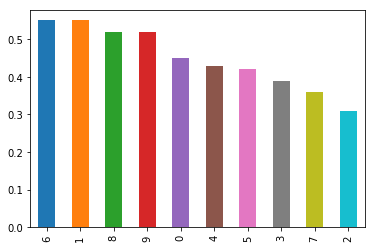

In [29]:
pd.Series(ix_counts).sort_values(ascending=False).plot(kind='bar')